In [1]:
%load_ext cython
import speckle_tracking as st
import robust_speckle_tracking as rst
from robust_speckle_tracking.bin import *
from robust_speckle_tracking import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from scipy.integrate import quad
from scipy.optimize import least_squares
from importlib import reload

pyximport.install(reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x7fd2b044f950>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'init_stars', 'krig_data', 'make_frames', 'make_reference', 'mse_2d', 'newton_1d', 'np', 'total_mse', 'upm_newton_1d', 'upm_search']


In [79]:
def st_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5):
    """
    Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
    u, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                            y_ps, z, df, verbose=False)
    I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

    es = []
    for i in range(n_iter):

        # calculate errors
        error_total = st.calc_error(I_n, M, W, dij_pix, I0, u, n0, m0, subpixel=True, verbose=False)[0]

        # store total error
        es.append(error_total)

        # update pixel map
        u = st.update_pixel_map(I_n, M, W, I0, u, n0, m0, dij_pix,
                                search_window=[1, u_max], subpixel=True,
                                fill_bad_pix=True, integrate=False,
                                quadratic_refinement=True, verbose=False)[0]
        u_max = int(np.max(np.abs(u - np.indices(W.shape))))

        # make reference image
        I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)

        # update translations
        dij_pix = st.update_translations(I_n, M, W, I0, u, n0, m0, dij_pix)[0]
    return {'u':u, 'I0':I0, 'errors':es}

def pixel_translations(basis, dij, df, z):
    dij_pix = (basis * dij[:, None]).sum(axis=-1)
    dij_pix /= (basis**2).sum(axis=-1) * df / z
    dij_pix -= dij_pix.mean(axis=0)
    return np.ascontiguousarray(dij_pix[:, 0]), np.ascontiguousarray(dij_pix[:, 1])

def str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=100, n_iter=5, l_scale=2.5):
    """
    Robust version of Andrew's speckle tracking update algorithm
    
    I_n - measured data
    W - whitefield
    basis - detector plane basis vectors
    x_ps, y_ps - x and y pixel sizes
    z - distance between the sample and the detector
    df - defocus distance
    u_max - pixel mapping search window size
    n_iter - number of iterations
    """
    I_n = I_n.astype(np.float64)
    W = W.astype(np.float64)
    u0 = np.indices(W.shape, dtype=np.float64)
    di, dj = pixel_translations(basis, dij, df, z)
    I0, n0, m0 = make_reference(I_n, W, u0, di, dj, l_scale)

    es = []
    for i in range(n_iter):

        # calculate errors
        es.append(total_mse(I_n, W, I0, u0, di - n0, dj - m0, l_scale))

        # update pixel map
        u = upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, u_max, l_scale)
        u_max = int(np.max(np.abs(u - u0)))
        u0 = u0 + gaussian_filter(u - u0, (0, 0, l_scale))

        # make reference image
        I0, n0, m0 = make_reference(I_n, W, u0, di, dj, l_scale)
        I0 = gaussian_filter(I0, (0, l_scale))
    return {'u':u0, 'I0':I0, 'errors':es}

In [4]:
def ab_model(pix, coeff):
    return coeff[0] + coeff[1] * (pix - coeff[3]) + coeff[2] * (pix - coeff[3])**2

def ab_errors(coeff, data, weights):
    return weights * (ab_model(data[:, 0], coeff) - data[:, 1])

def ph_model(theta, coeff):
    return coeff[0] + coeff[1] * (theta - coeff[4]) + \
           coeff[2] * (theta - coeff[4])**2 + coeff[3] * (theta - coeff[4])**3

def ph_errors(coeff, data):
    return ph_model(data[:, 0], coeff) - data[:, 1]

def phase_fit(u, x_ps, z, df, wl, u_var=1e-6, l_scale=5, max_order=4, roi=None):
    # calculate the phase
    if roi is None:
        roi = (0, u.shape[-1])
    u_pix = (u - np.indices((u.shape[1], u.shape[2])))[1, 0, roi[0]:roi[1]]
    ang = u_pix * x_ps / z
    phase = np.cumsum(ang) * x_ps * df / z * 2 * np.pi / wl
    pix = np.arange(u.shape[2])[roi[0]:roi[1]]
    x, theta = pix * x_ps, pix * x_ps / z

    data = np.stack((pix, gaussian_filter(u_pix, l_scale)), axis=-1)
    w = np.tanh(data[:, 1]**2 / u_var)

    # find a min/max argument
    u0 = gaussian_filter(u_pix, u_pix.shape[0] / 10)
    if np.median(np.gradient(np.gradient(u0))) > 0:
        idx = np.argmin(u0)
    else:
        idx = np.argmax(u0)

        
    # fit the model to the data
    bounds = ([-np.inf, -np.inf, -np.inf, 0],
              [np.inf, np.inf, np.inf, u_pix.shape[0]])
    fit = least_squares(ab_errors, np.array([0, 0, 0, pix[idx]]), args=(data, w),
                          xtol=1e-14, ftol=1e-14, bounds=bounds, loss='cauchy')
    ang_fit = np.array([fit.x[0], fit.x[1] / (x_ps / z),
                        fit.x[2] / (x_ps / z)**2, fit.x[3]]) * x_ps / z
    ph_fit = np.zeros(5)
    ph_fit[1:] = ang_fit; ph_fit[1:-1] *= 2 * np.pi / wl * df / (np.arange(3) + 1)
    ph_fit[0] = np.mean(phase - ph_model(theta, ph_fit))

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(fit.x, data, w)**2) / np.sum((w * (data[:, 1] - data[:, 1].mean()))**2)
    return {'pix': pix, 'theta': theta, 'u_pix': u_pix, 'angles': ang, 'phase': phase,
            'fit': fit, 'ang_fit': ang_fit, 'ph_fit': ph_fit, 'r_sq': r_sq}

# ST Simulation

In [5]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.1, bar_atn=0.2,
                           bulk_atn=0.2, p0 = 3e4, th_s=8e-5, n_frames=100,
                           offset=2., step_size=0.1, defoc=150, alpha=0.06,
                           ap_x=32, x0=0.7, random_dev=0.8)

globals().update(**params.export_dict())

In [414]:
n_x = int(1.6 * ap_x / focus * defoc * fs_size * pix_size / wl / det_dist)
n_y = int(1.2 * ap_y * ss_size * pix_size / wl / det_dist)
x_arr = np.linspace(-0.8 * ap_x / focus * defoc, 0.8 * ap_x / focus * defoc, n_x)
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, n_y)
xx_arr = pix_size * np.arange(-fs_size // 2, fs_size // 2)
yy_arr = pix_size * np.arange(-ss_size // 2, ss_size // 2)

In [415]:
wf0_x = lens(x_arr, wl, ap_x, focus, defoc, alpha, (x0 - 0.5) * ap_x)
wf0_y = aperture(y_arr, focus + defoc, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, yy_arr, det_dist, wl)
print(n_x, n_y)

3862 905


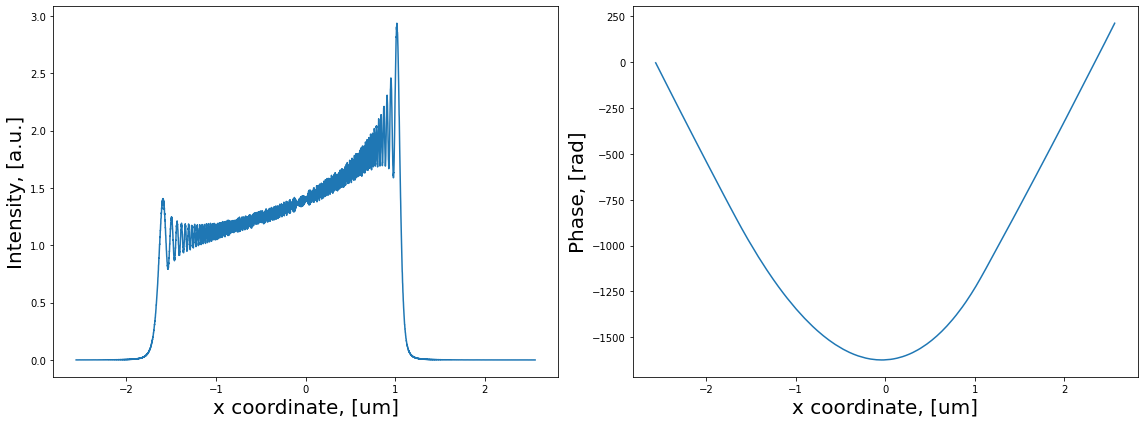

In [416]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_x.pdf')

In [602]:
fx_lim = np.array([-0.45 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / defoc
beam_span = np.clip(th_lim * defoc, x_arr[0], x_arr[-1])
wf0_roi = ((beam_span - x_arr[0]) // (x_arr[1] - x_arr[0])).astype(np.int)
xr_arr = x_arr[wf0_roi[0]:wf0_roi[1]]
wf0_ph = np.unwrap(np.angle(wf0_x))
wf0_ph_fc = np.polyfit(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], 3)
df_fit = np.pi / wl / wf0_ph_fc[1]
alpha_fit = wf0_ph_fc[0] * df_fit**3 * 1e-9
wf0_ph_fit = np.pi * xr_arr**2 / wl / df_fit + alpha_fit * 1e9 * (xr_arr / df_fit)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
wf0_ph_th = np.pi * xr_arr**2 / wl / defoc + alpha * 1e9 * (xr_arr / defoc)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
print(df_fit, alpha_fit)

127.9737119286444 0.05121878612560181


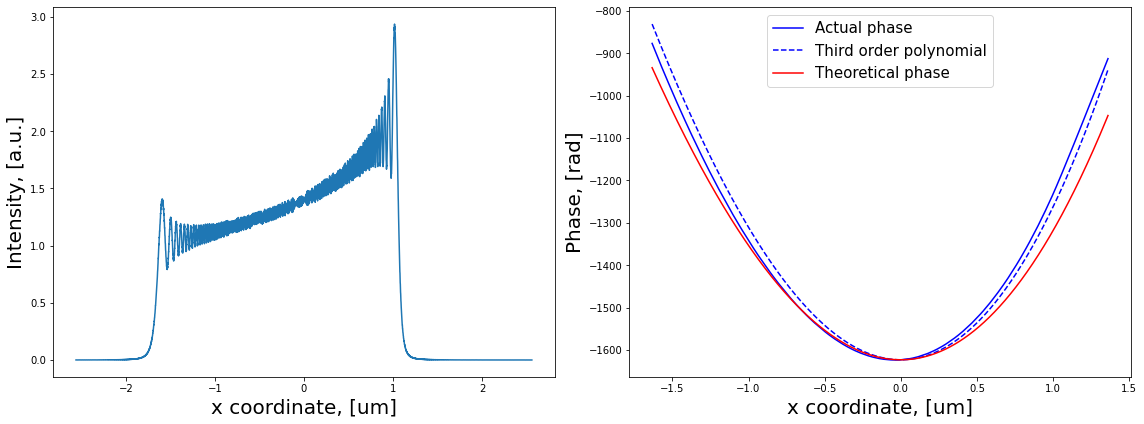

In [603]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], label='Actual phase', color='b')
axes[1].plot(xr_arr, wf0_ph_fit, color='b', label='Third order polynomial', linestyle='dashed')
axes[1].plot(xr_arr, wf0_ph_th, color='r', label='Theoretical phase')
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_phase_2.pdf')

In [658]:
bsteps = barcode_steps(x0=x_arr[0] + offset, x1=x_arr[-1] + n_frames * step_size - offset,
                       br_dx=bar_size, rd=random_dev)
bs_t = barcode_2d(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn, step_size, n_frames)
# bs_t = barcode_1d(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn)
wf1_x = fraunhofer_2d(wf0_x * bs_t, x_arr, xx_arr, det_dist, wl)
print(bsteps)

[-0.14028924  0.18216982  0.63870176  1.83956697  2.2390223   2.92219275
  4.13456694  5.10818892  5.85303782  6.82178516  7.81292222  8.69059522
  9.18410936 10.22504074]


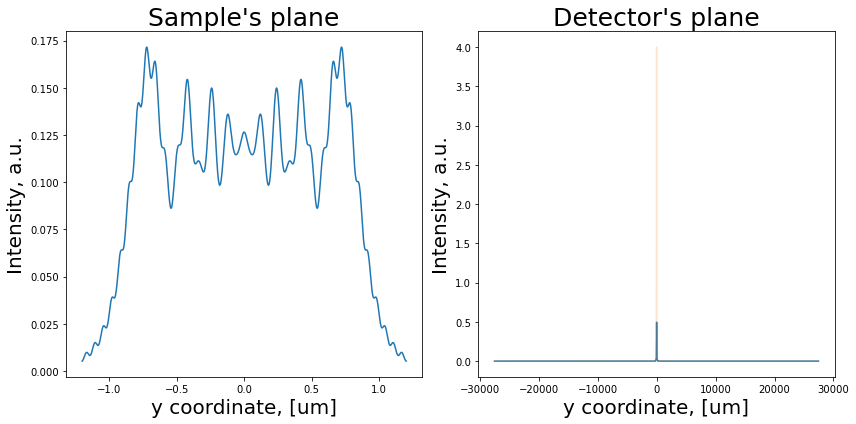

In [605]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(yy_arr, np.abs(wf1_y)**2)
axes[1].plot(yy_arr, (ap_y * np.sinc(np.pi * ap_y * yy_arr / wl / (det_dist + focus + defoc)))**2, alpha=0.2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

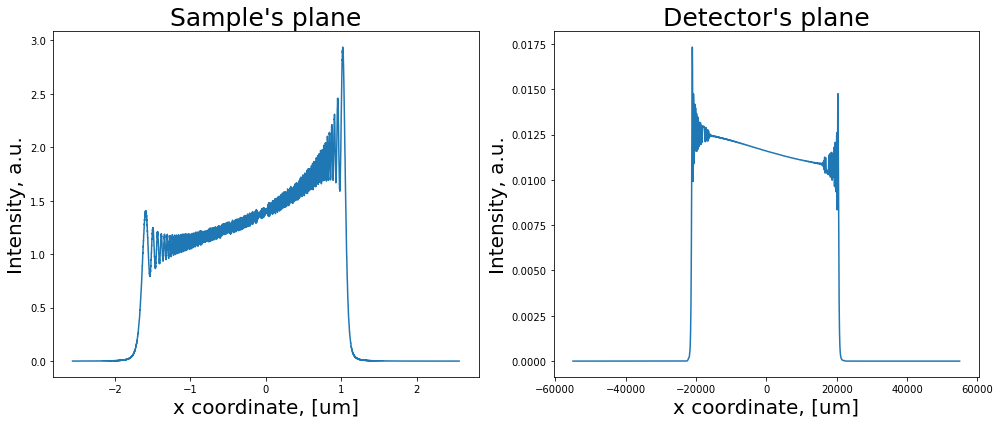

In [606]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(xx_arr, np.abs(wf1_x[0])**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

In [659]:
sigma = th_s * det_dist
sx_arr = pix_size * np.arange(-np.ceil(4 * sigma / pix_size), np.ceil(4 * sigma / pix_size) + 1)
s_arr = np.exp(-sx_arr**2 / 2 / sigma**2)
s_arr /= s_arr.sum()
print(sigma / pix_size)

2.909090909090909


In [683]:
det_c = 1 / wl**2 / (focus + defoc) / det_dist
i0 = p0 / ap_x / ap_y
data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                   sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)
beam_span = np.tan(th_lim) * (det_dist + defoc)
x_roi = np.clip((beam_span - xx_arr.min()) // pix_size, 0, fs_size).astype(np.int)
roi = (data.shape[1] // 2, data.shape[1] // 2 + 1, x_roi[0], x_roi[1])
ptych = data[:, :, roi[2]:roi[3]].sum(axis=1)
mask = np.ones((data.shape[1], data.shape[2]), dtype=np.uint8)
whitefield = make_whitefield(data, mask)
print(data.shape, np.mean(ptych[..., 20:-20]), np.std(ptych[..., 20:-20]),
      np.std(ptych[..., 20:-20]) / np.sqrt(np.mean(ptych[..., 20:-20])))

(100, 1, 2000) 26.505889212827988 3.924111792981884 0.7622021722826126


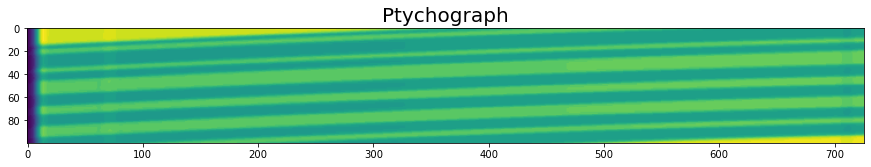

In [684]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(ptych)
ax.set_title('Ptychograph', fontsize=20)
plt.show()

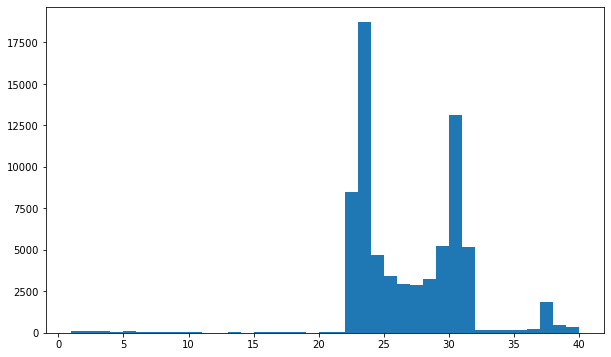

In [685]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ptych.ravel(), min(int(ptych.max() - ptych.min()), 100))
plt.show()

In [5]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                   sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

NameError: name 'i0' is not defined

In [ ]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                   sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [5]:
dir_path = 'results/test_ideal'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

st_data0 = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
st_obj0 = st_data0.get_last_st()
st_res0, errors = st_obj0.iter_update(150, ls_pm=2.5, ls_ri=15, verbose=True, n_iter=10)

Iteration No. 0: Total MSE = 0.177
Iteration No. 1: Total MSE = 0.105
Iteration No. 2: Total MSE = 0.064
Iteration No. 3: Total MSE = 0.057
Iteration No. 4: Total MSE = 0.054
Iteration No. 5: Total MSE = 0.053


In [6]:
dir_path = 'results/test'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

st_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
st_obj = st_data.get_last_st()
st_res, errors = st_obj.iter_update(150, ls_pm=2.5, ls_ri=15, verbose=True, n_iter=10)

Iteration No. 0: Total MSE = 0.283
Iteration No. 1: Total MSE = 0.223
Iteration No. 2: Total MSE = 0.191
Iteration No. 3: Total MSE = 0.185
Iteration No. 4: Total MSE = 0.183
Iteration No. 5: Total MSE = 0.183


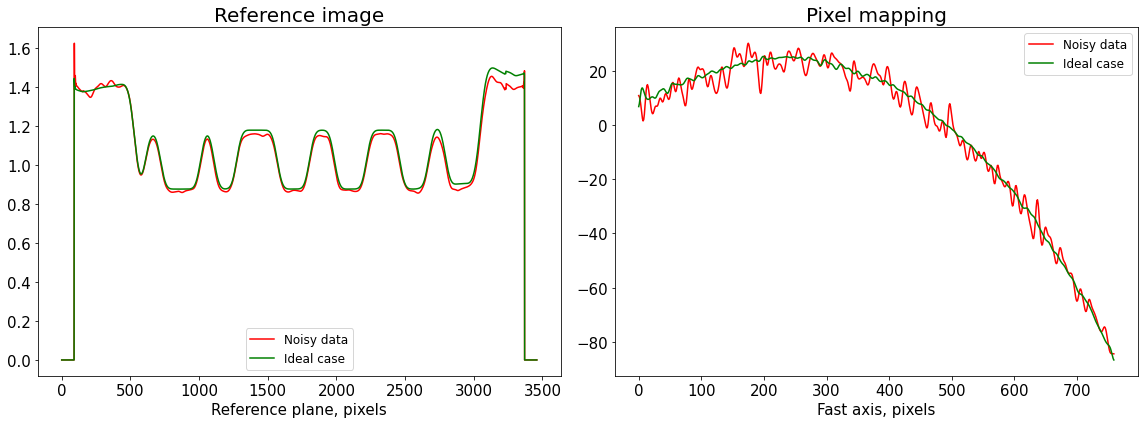

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], 'r', label='Noisy data')
axes[0].plot(st_res0.reference_image[0], 'g', label='Ideal case')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].plot((st_res0.pixel_map - st_obj.pixel_map)[1, 0], 'g', label='Ideal case')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

In [14]:
data_path = 'results/exp/Scan_1986.cxi'

loader = rst.loader()
st_data = loader.load(data_path, roi=(0, 1, 360, 1090), defocus=1.0e-4)
st_data = st_data.make_whitefield()
st_data = st_data.make_pixel_map()
st_obj = st_data.get_last_st()
# st_res, errors = st_obj.iter_update(200, l_scale=2.5, verbose=False, n_iter=1)

In [17]:
sw_max = 400
k = 800
sw = np.arange(-sw_max, sw_max)
ls = 3.

st_obj = st_obj.update_reference(l_scale=ls)

fs = np.clip(sw[:, None, None] + (st_obj.pixel_map[1, 0] - st_obj.dfs_pix[:, None]),
             0, st_obj.reference_image.shape[1] - 1)
ffs = np.clip((st_obj.pixel_map[1, 0] - st_obj.dfs_pix[:, None]),
             0, st_obj.reference_image.shape[1] - 1)

I = gaussian_filter(st_obj.data[:, 0] / st_obj.whitefield[0], (0, ls))
dI = I - st_obj.reference_image[0, fs.astype(int)]
dI0 = (I - 1)[None, :]

mse = np.sum(dI**2, axis=1) / np.sum(dI0**2, axis=1)
mse_var = (np.sum(dI**2, axis=1) / np.sum(dI0**2, axis=1)**2 + \
           np.sum(dI**2, axis=1)**2 / np.sum(dI0**2, axis=1)**3) / 2 / ls

In [146]:
# st_obj0 = st_obj0.update_reference(l_scale=ls)

# fs0 = np.clip(sw[:, None, None] + (st_obj0.pixel_map[1, 0] - st_obj0.dfs_pix[:, None]),
#              0, st_obj0.reference_image.shape[1] - 1)

# I_0 = gaussian_filter(st_obj0.data[:, 0] / st_obj0.whitefield[0], (0, ls))
# dI_0 = I_0 - st_obj0.reference_image[0, fs0.astype(int)]
# dI0_0 = (I_0 - 1)[None, :]

# mse0 = np.sum(dI_0**2, axis=1) / np.sum(dI0_0**2, axis=1)

# mse.shape, mse0.shape

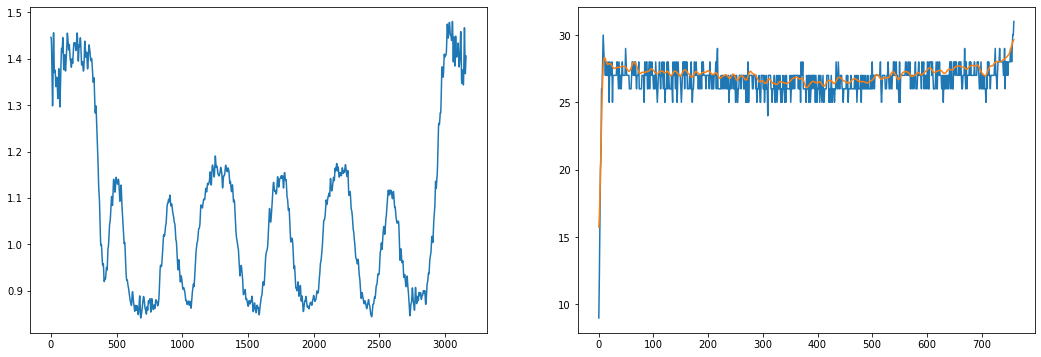

In [24]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(dev.make_reference(st_obj.data, st_obj.whitefield, st_obj.pixel_map,
                                st_obj.dss_pix, st_obj.dfs_pix, ls, wfs=0)[0][0])
axes[1].plot(st_obj.whitefield[0])
axes[1].plot(gaussian_filter(np.mean(st_obj.data[:, 0], axis=0), ls))
plt.show()

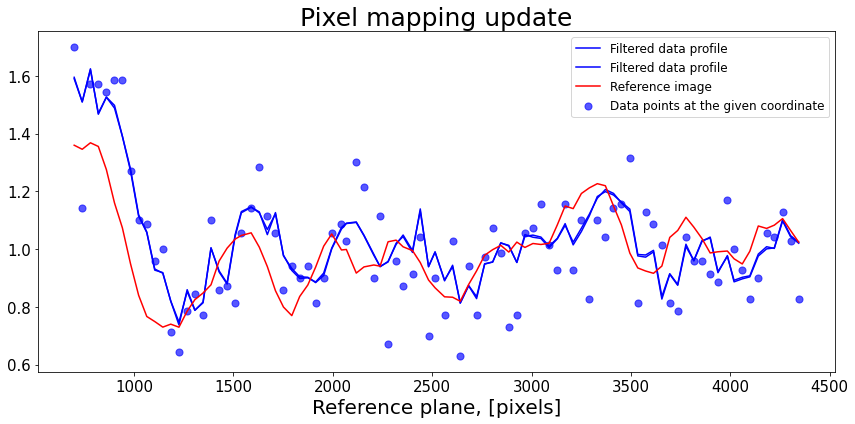

In [165]:
%matplotlib inline
k = 700
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(ffs[:, k], st_obj.data[:, 0, k] / st_obj.whitefield[0, k], s=50, c='b', alpha=0.66, label='Data points at the given coordinate')
# ax.plot(ffs[:, (k - n):(k + n)].ravel(), st_obj.data[:, 0, (k - n):(k + n)].ravel(), 'b--', alpha=0.5,
#         label='Data points in the vicinity (+-{:d} pixels)'.format(n))
ax.plot(ffs[:, k], I[:, k], 'b',
        label='Filtered data profile')
ax.plot(ffs[:, k], dev.krig_data(st_obj.data, st_obj.whitefield, st_obj.pixel_map, 0, k, ls)[0], 'b',
        label='Filtered data profile')
ax.plot(ffs[:, k], st_obj.reference_image[0, ffs[:, k].astype(int)], 'r',
        label='Reference image')
ax.set_xlabel('Reference plane, [pixels]', fontsize=20)
ax.set_title('Pixel mapping update', fontsize=25)
ax.legend(fontsize=12)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_explanations.pdf')

In [25]:
st_nols = st_obj.update_reference(l_scale=0.1)
mse_nols = dev.mse_2d(I_n=st_nols.data, W=st_nols.whitefield, I0=st_nols.reference_image, u=st_nols.pixel_map, \
                      di=st_nols.dss_pix, dj=st_nols.dfs_pix, wss=1, wfs=sw_max, ls=0.1)
mse_c = dev.mse_2d(I_n=st_obj.data, W=st_obj.whitefield, I0=st_obj.reference_image, u=st_obj.pixel_map,
                   di=st_obj.dss_pix, dj=st_obj.dfs_pix, wss=1, wfs=sw_max, ls=ls)

%time u_search = upm_search(I_n=st_obj.data, W=st_obj.whitefield, I0=st_obj.reference_image, \
                                u0=st_obj.pixel_map, di=st_obj.dss_pix, dj=st_obj.dfs_pix, \
                                wss=1, wfs=sw_max, ls=ls)
%time u_iter = dev.upm_newton_1d(I_n=st_obj.data, W=st_obj.whitefield, I0=st_obj.reference_image, \
                               u0=st_obj.pixel_map, di=st_obj.dss_pix, dj=st_obj.dfs_pix, \
                               wfs=sw_max, ls=ls)
# %time u0_search = upm_search(I_n=st_obj0.data, W=st_obj0.whitefield, I0=st_obj0.reference_image, \
#                                  u0=st_obj0.pixel_map, di=st_obj0.dss_pix, dj=st_obj0.dfs_pix, \
#                                  wss=1, wfs=sw_max, ls=10.)

CPU times: user 791 ms, sys: 2.54 ms, total: 793 ms
Wall time: 71.3 ms
CPU times: user 295 ms, sys: 3.69 ms, total: 299 ms
Wall time: 26.4 ms


In [42]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'init_stars', 'krig_data', 'make_frames', 'make_reference', 'mse_2d', 'newton_1d', 'np', 'total_mse', 'upm_newton_1d', 'upm_search']


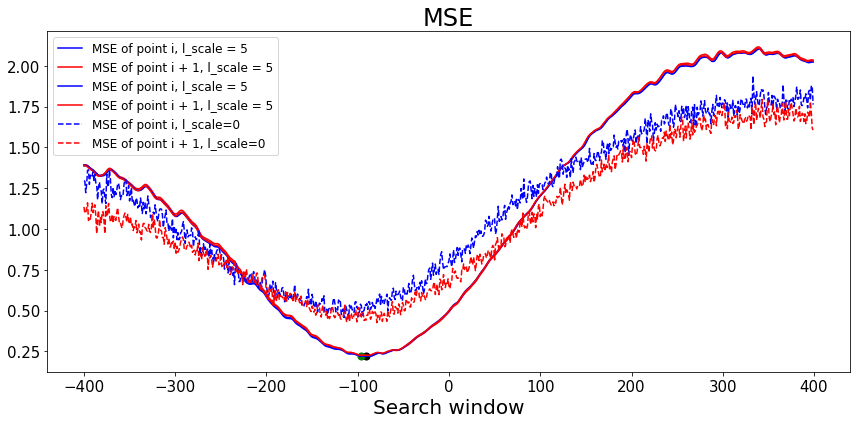

In [167]:
%matplotlib inline
k = 700
fig, ax = plt.subplots(figsize=(12, 6))
# ax.fill_between(sw, mse[:, k] - np.sqrt(mse_var[:, k]),
#                     mse[:, k] + np.sqrt(mse_var[:, k]), alpha=0.7, label = 'Standard deviation')
ax.plot(sw, mse[:, k], 'b-', label='MSE of point i, l_scale = 5')
ax.plot(sw, mse[:, k + 1], 'r-', label='MSE of point i + 1, l_scale = 5')
ax.plot(sw, mse_c[0, k, 1, :], 'b-', label='MSE of point i, l_scale = 5')
ax.plot(sw, mse_c[0, k + 1, 1, :], 'r-', label='MSE of point i + 1, l_scale = 5')
ax.plot(sw, mse_nols[0, k, 1, :], 'b--', label='MSE of point i, l_scale=0')
ax.plot(sw, mse_nols[0, k + 1, 1, :], 'r--', label='MSE of point i + 1, l_scale=0')
# ax.plot(sw, mse0[:, k], 'g', label='MSE of point i for the ideal case (No noise)')
ax.scatter(u_iter[1, 0, k] - st_obj.pixel_map[1, 0, k], mse[:, k].min(), s=50, c='k')
ax.scatter(u_search[1, 0, k] - st_obj.pixel_map[1, 0, k], mse[:, k].min(), s=50, c='g')
ax.set_title('MSE', fontsize=24)
ax.legend(fontsize=12)
ax.tick_params(labelsize=15)
ax.set_xlabel('Search window', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_MSE.pdf')

In [705]:
n_iter = 10
ls, ls0 = 2., 15.
sw_max = 200

I_n = st_obj.data
W = st_obj.whitefield
di = st_obj.dss_pix
dj = st_obj.dfs_pix.copy()
dj += (st_obj.dfs_pix.max() - st_obj.dfs_pix.min()) / 2 - st_obj.dfs_pix.max()
u0 = st_obj.pixel_map.copy()

I0, n0, m0 = dev.make_reference(I_n, W, u0, di, dj, ls0, wfs=sw_max)
print(-m0, I0.shape[1] - m0, I0.shape)

for i in range(n_iter):
    u = dev.upm_newton_1d(I_n, W, I0 , u0, di - n0, dj - m0, sw_max, ls)
    I, n, m = dev.make_reference(I_n, W, u, di, dj, ls0, wfs=0)
    print(-m, I.shape[1] - m)

    roi = slice(m0 - m, I.shape[1] + m0 - m)
    I0[:, roi] += gaussian_filter(I - I0[:, roi], (0, ls0))
    u0 += gaussian_filter(u - u0, (0, 0, ls))

-1661 3112 (1, 4773)
-1497 2814
-1498 2821
-1496 2827
-1495 2832
-1495 2849
-1494 2857
-1494 2859
-1493 2861
-1492 2861
-1491 2862


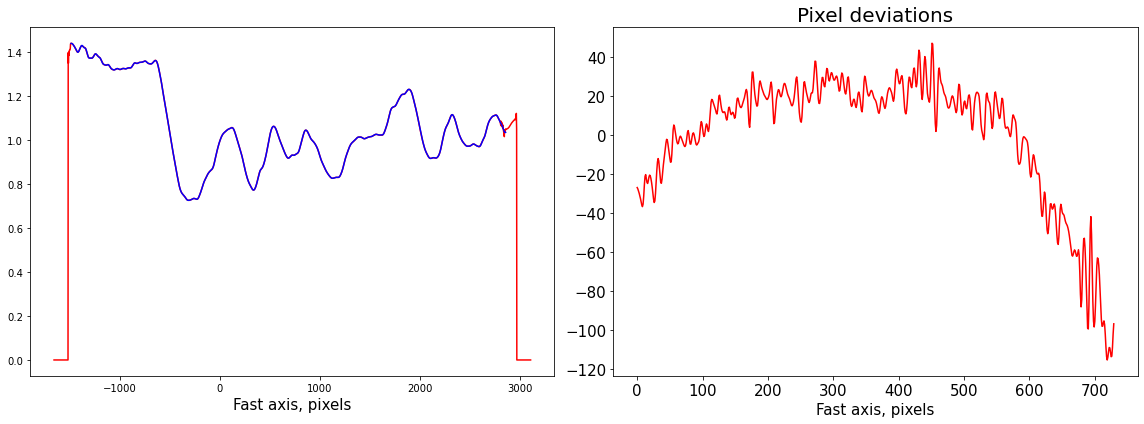

In [706]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# axes[0].plot(st_res0.reference_image[0], 'g')
axes[0].plot(np.arange(I0.shape[1]) - m0, I0[0], 'r')
axes[0].plot(np.arange(I.shape[1]) - m, I[0], 'b')
axes[1].plot((u0 - st_obj.pixel_map)[1, 0], 'r', label="Newton's method")
axes[1].set_title('Pixel deviations', fontsize=20)
# axes[1].plot((st_res0.pixel_map - st_obj0.pixel_map)[1, 0], c='g', label="Ideal")
# ax.plot(u_newton, 'g--')
for ax in axes:
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
# ax.legend(fontsize=12)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results.pdf')

# Simulation results

In [5]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

di, dj = pixel_translations(basis, dij, df, z)
I_n, W = I_n.astype(np.float64), W.astype(np.float64)
I_n.shape[-1], (dij[0] - dij[1]), basis[0]

(726,
 array([1.e-07, 0.e+00, 0.e+00]),
 array([[ 0.0e+00, -5.5e-05,  0.0e+00],
        [ 5.5e-05,  0.0e+00,  0.0e+00]]))

In [14]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, ls=20.,return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

10.427397332159932 29.94749999999999 726
3.3278424749337812e-06


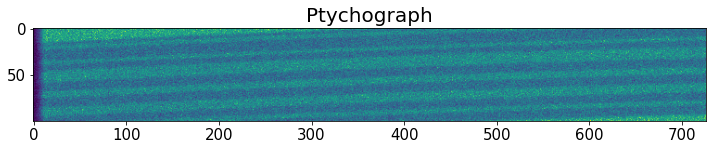

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [345]:
params = st_sim.parameters()

fx = params.ap_x / 2 / params.focus
z_bar = params.defoc * params.det_dist / (params.defoc + params.det_dist)
th_max = abs(params.wl / 2 / np.pi * params.alpha * 3e9 * fx**2 / (params.defoc + z_bar))
sw_max = max(int(2 * th_max / params.pix_size * params.det_dist), 10)
print(sw_max, th_max)

28 0.00038678518249739865


In [45]:
#---------------------------
# Initialise
#---------------------------

# generate pixel map
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
l_scale = 5
dss = np.mean(np.abs(di[1:] - di[:-1]))
dfs = min(np.abs(dj[1] - dj[0]) / 5, 40) / 10

I0, n0, m0 = make_reference(I_n, W, u0, di, dj, ls=10)
I0_nols = make_reference(I_n, W, u0, di, dj, ls=0.01, return_nm0=False)
I0_avg = make_reference(I_n, W, u0, di, dj, ls=30, return_nm0=False)
u_stars = upm_search(I_n, W, I0, u0, di - n0, dj - m0, wss=1, wfs=150, ls=10.)
print(I0.shape)

(1, 3126)


In [46]:
#---------------------------
# Intialise
#---------------------------
u0, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                         y_ps, z, df, verbose=False)
I0_nols = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)[0]
u = st.update_pixel_map(I_n.astype(np.float32), M, W, I0, u0, n0, m0, dij_pix,
                        search_window=[1, 100], subpixel=True,
                        fill_bad_pix=True, integrate=False,
                        quadratic_refinement=True, verbose=False)[0]

updating pixel map: 6.58e-01: 100%|██████████| 8/8 [00:00<00:00, 36.35it/s]


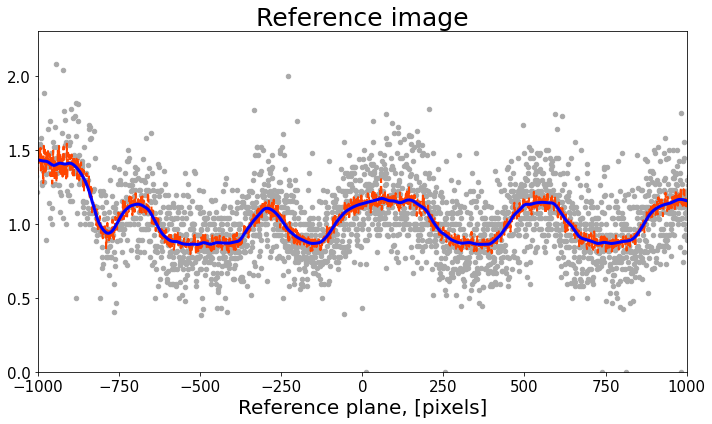

In [85]:
fs = u0[1, 0] - dj[:, None]

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(fs.ravel()[::20], (I_n / W).ravel()[::20], s=20, c='darkgrey')
ax.plot(np.arange(-m0, I0_nols.shape[1] - m0), I0_nols[0], c='orangered', linestyle='dashed', linewidth=2)
ax.plot(np.arange(-m0, I0.shape[1] - m0), I0[0], 'b', linewidth=3)
ax.set_xlabel('Reference plane, [pixels]', fontsize=20)
ax.set_title('Reference image', fontsize=25)
ax.set_ylim(0, 2.3)
ax.set_xlim(-1000, 1000)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/reference_image_update.pdf')

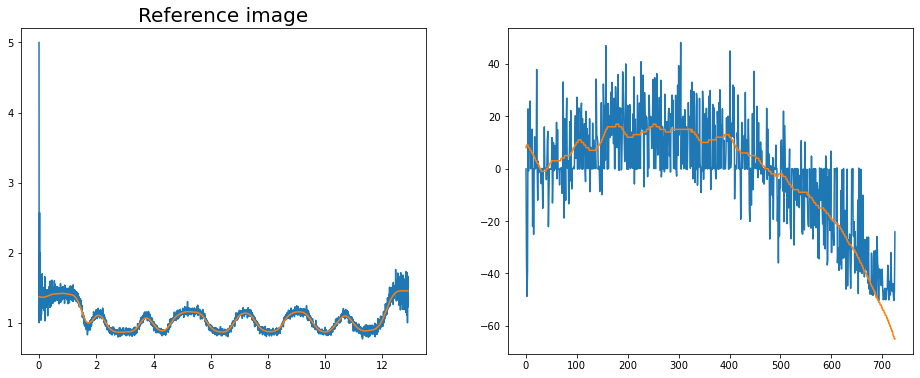

In [19]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0[0])
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0_avg[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((u - u0)[1, 0])
axes[1].plot((u_stars - u0)[1, 0])
plt.show()

In [106]:
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
I0 = make_reference(I_n, W, u, di, dj, ls=20)[0]
dI0 = np.gradient(I0[0])
dI0_avg = np.mean(dI0**2)
p_var = np.mean(I_n)
print(np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2)), K)
print(dI0_avg)

9.505362250980015 29.94749999999999
4.004767062859411e-06


In [107]:
st_res = st_update(I_n.astype(np.float32), W.astype(np.float32), dij, basis, x_ps, y_ps, z, df)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl)

updating object map and translations: 6.07e+01:   0%|          | 0/100 [00:00<?, ?it/s]


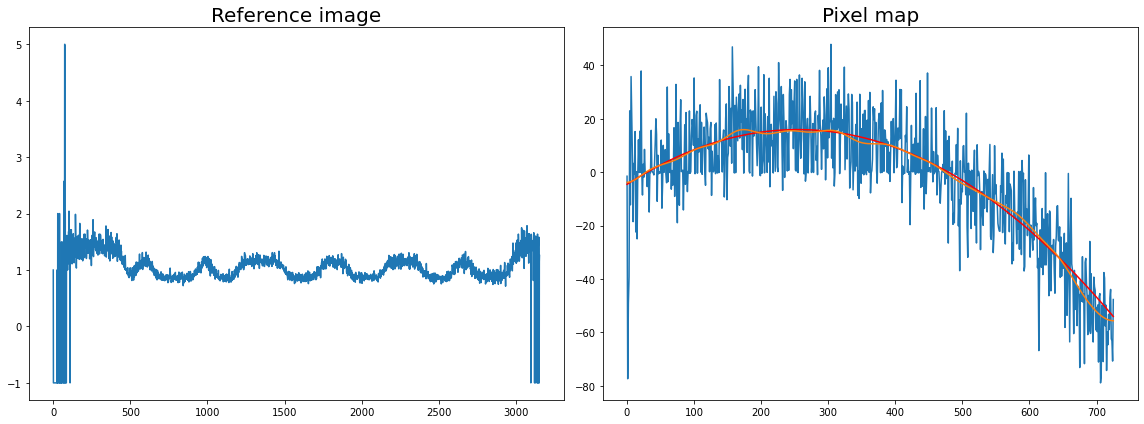

In [108]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].plot(ph_res['pix'], gaussian_filter(ph_res['u_pix'], 20))
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_simold.pdf')

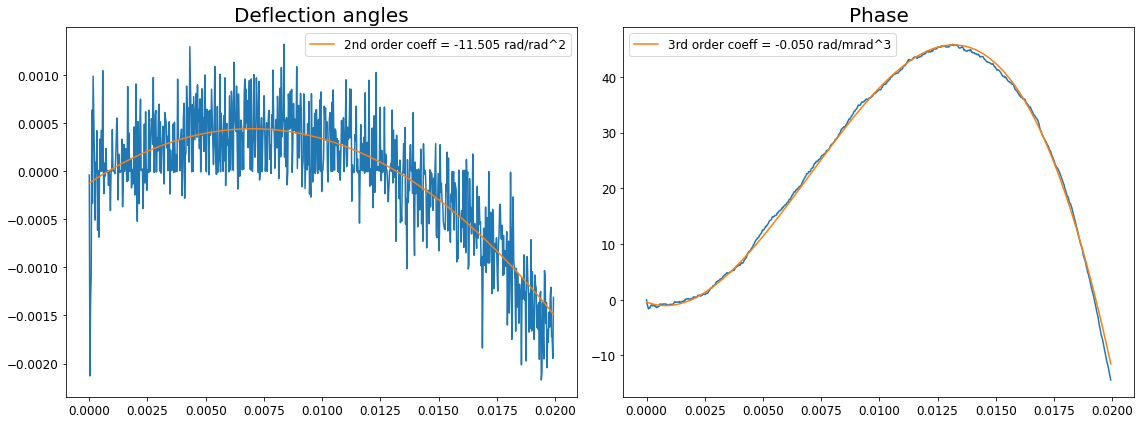

In [109]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_simold.pdf')

In [91]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, l_scale=7.5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var=20)

In [143]:
fit = phr_res['fit']
cov = np.linalg.inv(fit.jac.T.dot(fit.jac))
np.sqrt(np.sum(fit.fun ** 2) / (fit.fun.size - fit.x.size) * np.diag(cov))

array([2.66944410e+06, 2.21464247e+04, 5.74266905e-06, 2.88281300e+07])

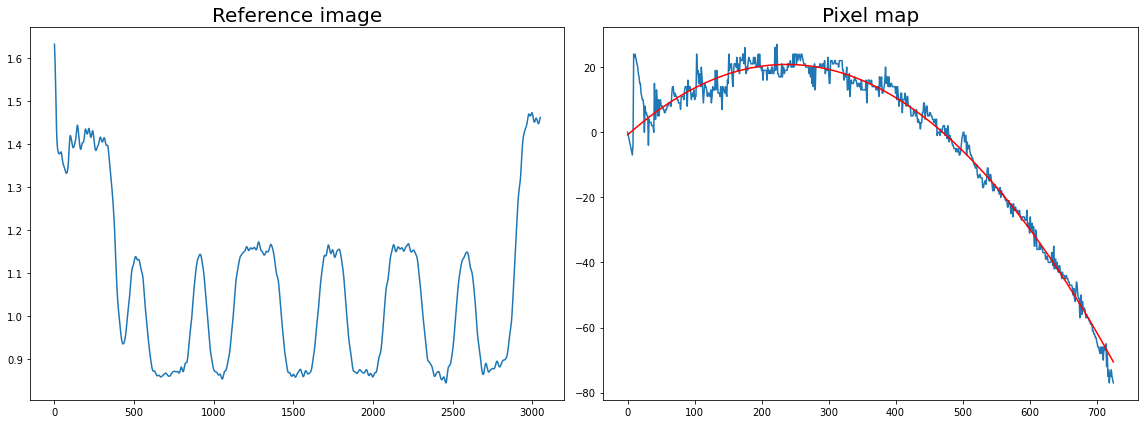

In [148]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

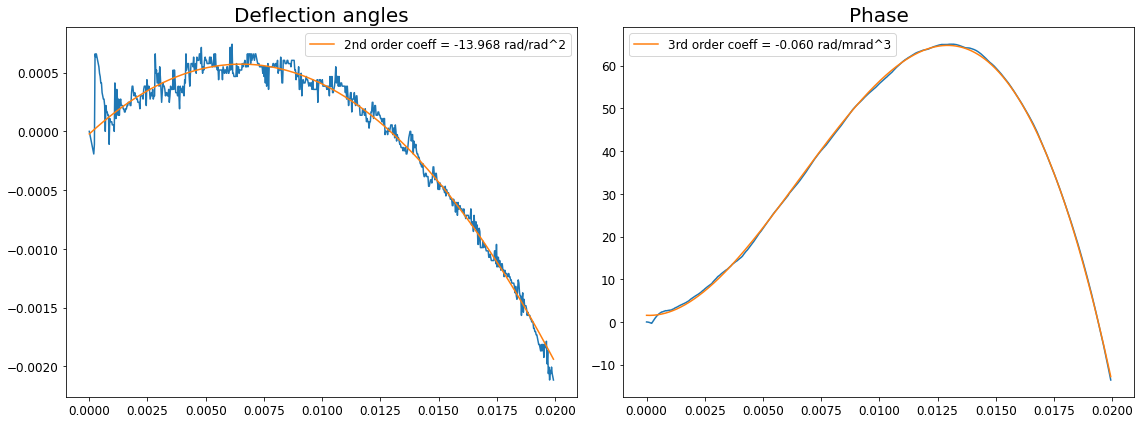

In [149]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(phr_res['theta'], phr_res['phase'])
axes[1].plot(phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_fits_5it.pdf')

# Experiment results

In [88]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2008

loader = rst.loader()
st_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num], defocus=1.0e-4)
st_data = st_data.update_defocus()
st_data = st_data.make_whitefield()
st_data = st_data.make_pixel_map()
st_obj = st_data.get_last_st()
st_res, errors = st_obj.iter_update(300, ls_ri=15., ls_pm=5., verbose=True, n_iter=10)
st_res.update_data()

Iteration No. 0: Total MSE = 0.179
Iteration No. 1: Total MSE = 0.087
Iteration No. 2: Total MSE = 0.084
Iteration No. 3: Total MSE = 0.084


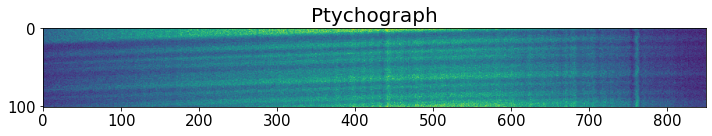

In [89]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(st_data.get('data')[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

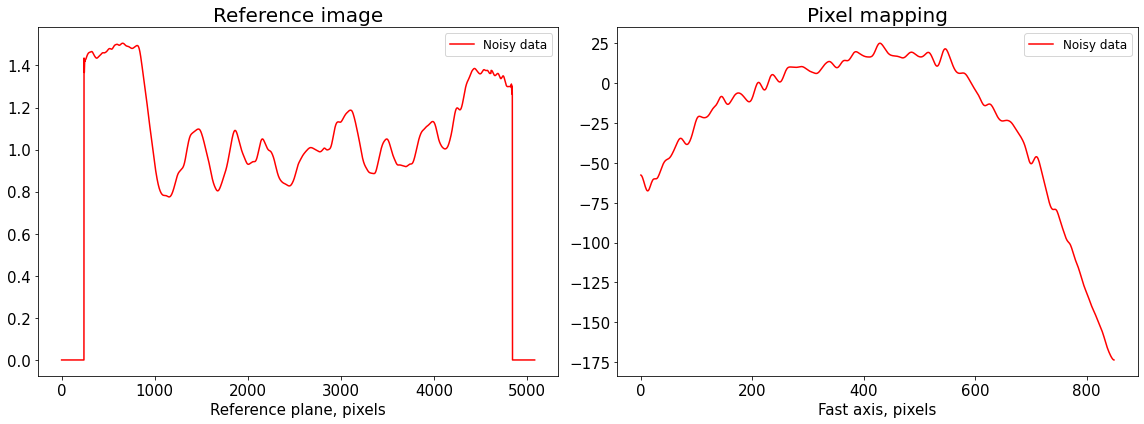

In [90]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], 'r', label='Noisy data')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

In [43]:
ab_fit = st_data.get_ab_fit()
fit_data = ab_fit.fit_pixel_ab(np.arange(st_res.pixel_map.shape[-1]),
                               (st_res.pixel_map - st_obj.pixel_map)[1, 0],
                               max_order=2)

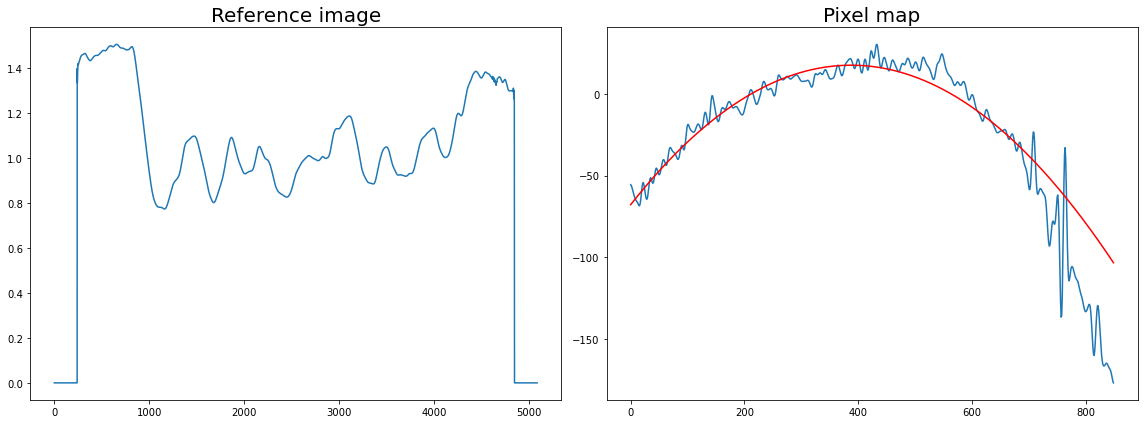

In [44]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(fit_data['pixels'], fit_data['pixel_ab'])
axes[1].plot(fit_data['pixels'], ab_fit.model(fit_data['fit'], fit_data['pixels']), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig('figures/st_results_robust_2008.pdf')

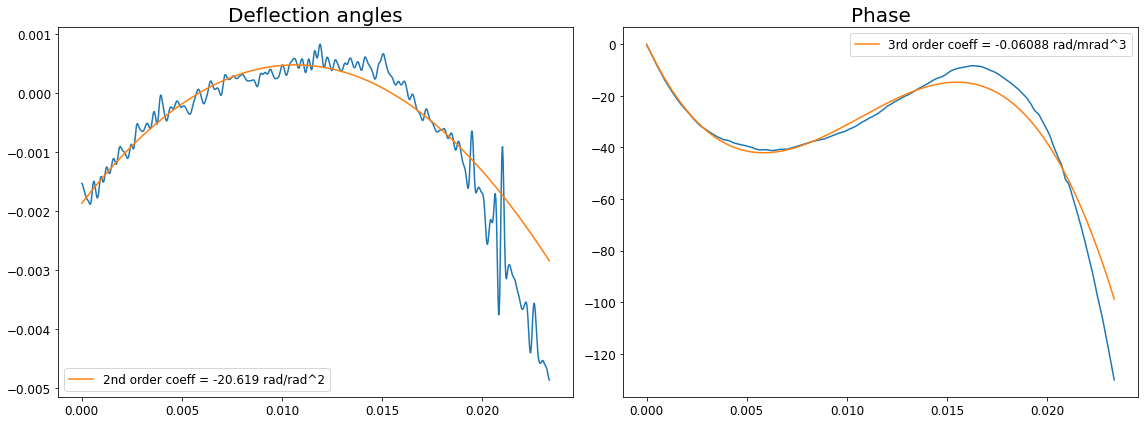

In [45]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('deviation_angles')[1, 0])
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, ab_fit.angles_model(fit_data['fit'], fit_data['pixels']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ab_fit.to_ang_fit(fit_data['fit'])[0]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('phase')[0])
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap,
             ab_fit.phase_model(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0]),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(
                 ab_fit.to_ph_fit(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0])[0] * 1e-9
             ))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
# plt.show()
plt.savefig('figures/st_fits_robust_2008.pdf')

In [71]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 2008

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]].sum(axis=1)[:, None]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 1e-4
I_n = I_n.astype(np.float64)
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield_st(I_n, M)
(dij[1] - dij[0]), I_n.shape[-1], np.mean(I_n), basis[0]

(array([0.0e+00, 9.6e-08, 0.0e+00]),
 850,
 72.90818870122307,
 array([[-5.5e-05,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -5.5e-05,  0.0e+00]]))

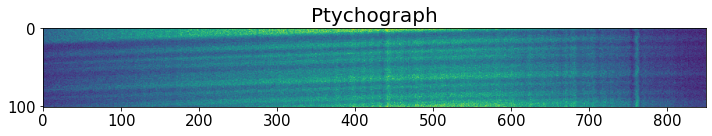

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [73]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, ls=20., return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

10.151162106893096 24.348958333599075 850
1.2507496085642653e-06


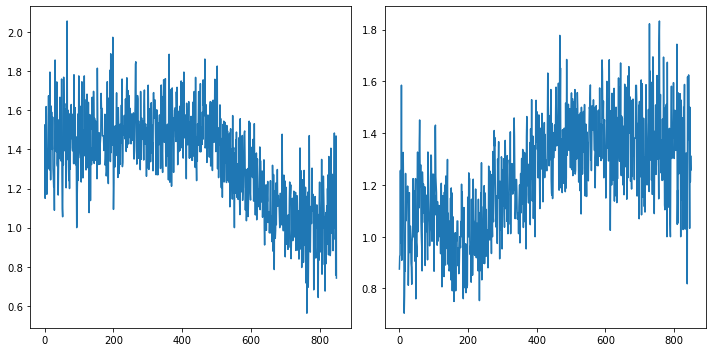

In [74]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_n[1, 0] / W[0] )
axes[1].plot(I_n[-1, 0] / W[0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [75]:
#---------------------------
# Intialise
#---------------------------
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
l_scale = 5.5
sw_max = 300

I0, n0, m0 = dev.make_reference(I_n, W, u0, di, dj, ls=l_scale, wfs=0)
I0_avg = dev.make_reference(I_n, W, u0, di, dj, ls=30, wfs=0)[0]
u = dev.upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, sw_max, l_scale)
# u = dev.upm_newton_1d(I_n, W, I0, u0, di, dj, sw_max, l_scale)
u = u0 + gaussian_filter(u - u0, (0, 0, l_scale))
print(I0.shape)

(1, 4484)


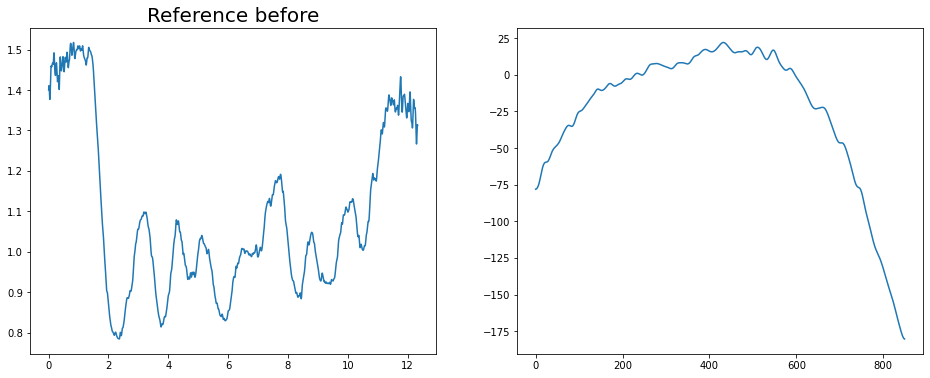

In [76]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0[0])
axes[0].set_title('Reference before', fontsize=20)
axes[1].plot((u - u0)[1, 0])
plt.show()
# plt.savefig('figures/reference_1595.pdf')

In [357]:
st_res = st_update(I_n.astype(np.float32), W, dij, basis, x_ps, y_ps, z, df, u_max=300)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl, u_var)

updating object map and translations: 3.71e+01:   0%|          | 0/100 [00:00<?, ?it/s]


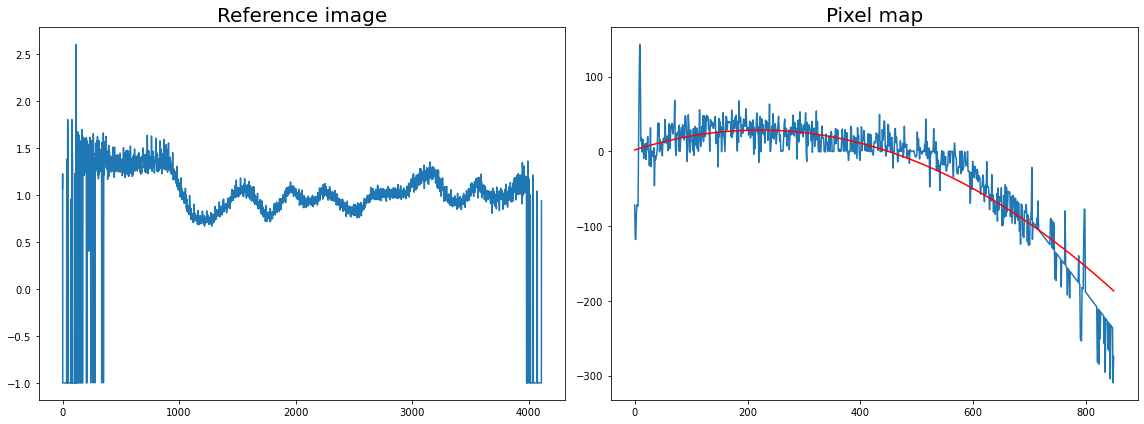

In [358]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_andrew_1727.pdf')

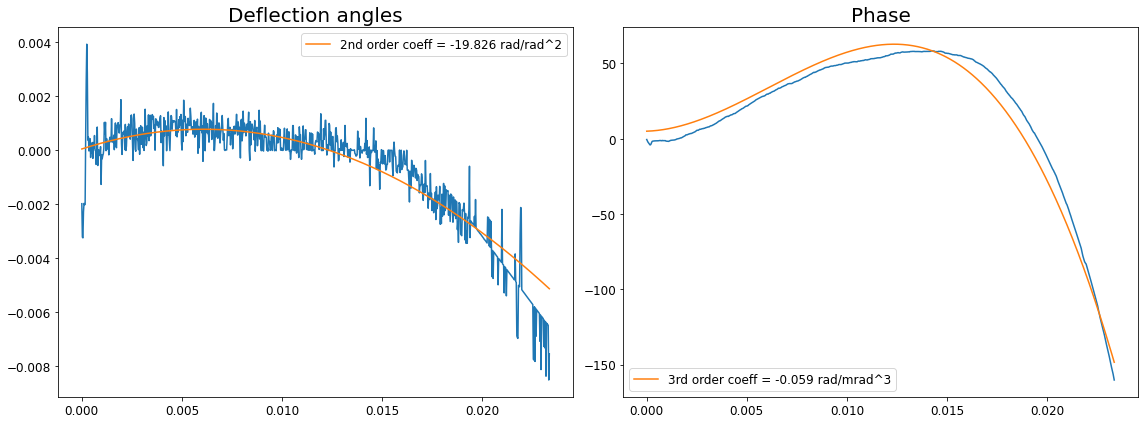

In [359]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_andrew_1727.pdf')

In [85]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=200, l_scale=7., n_iter=5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var)

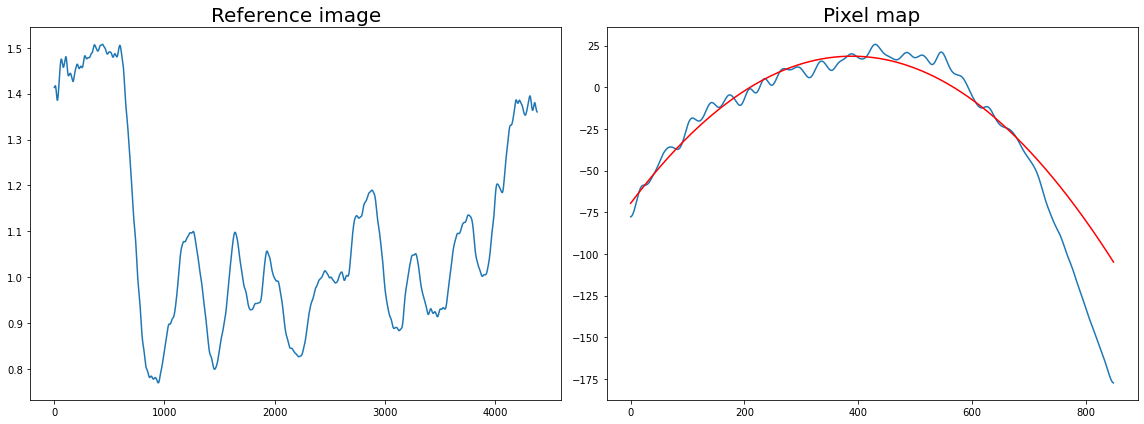

In [86]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_1896.pdf')

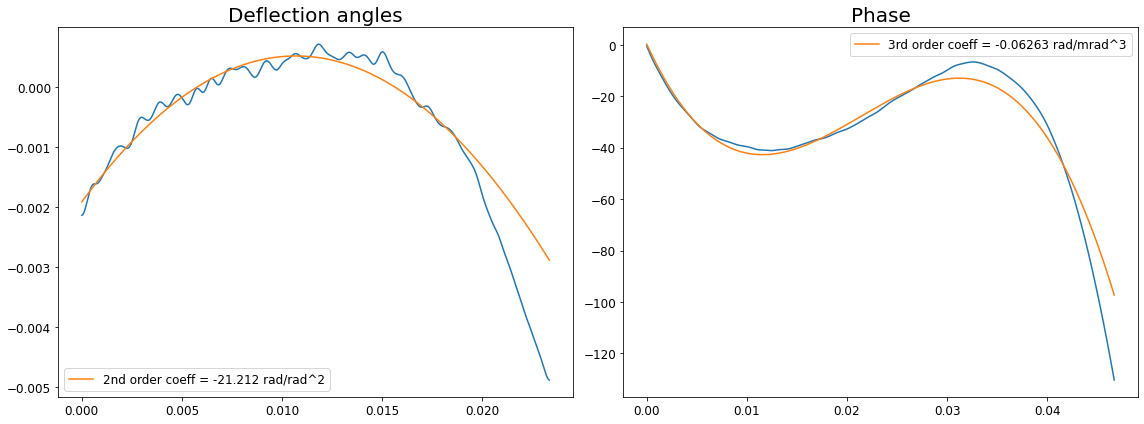

In [87]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(2 * phr_res['theta'], phr_res['phase'])
axes[1].plot(2 * phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_1896.pdf')